In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(denormalize(img).to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(img):
    return img.to('cpu') * torch.Tensor([0.229, 0.224, 0.225]).view((3,1,1)) + torch.tensor([[0.485, 0.456, 0.406]]).view((3,1,1))

def prepare_plots(attr, img):
    img = denormalize(img).numpy().transpose((1,2,0)) * 255
    attr = attr.to('cpu').numpy().transpose((1,2,0))
    return attr, img

# Download an example image from the pytorch website
filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)

# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

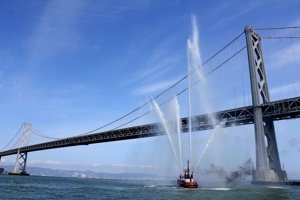

In [3]:
# sample execution (requires torchvision)
filename = "./data/fireboat.jpg"

from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)
image.resize((v//4 for v in image.size))

In [4]:
from torch import nn

input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# inference
input_batch.requires_grad = True
output = model(input_batch)
prob = output.softmax(-1)
log_prob = prob.log()

In [5]:
from functools import reduce

grad_vecs = torch.zeros((log_prob.shape[-1], reduce(lambda x,y:x*y, input_batch.shape),))

if torch.cuda.is_available():
    grad_vecs = grad_vecs.to("cuda")

for i in range(log_prob.shape[-1]):
    index = torch.zeros_like(log_prob)
    index[..., i] = 1
    log_prob.backward(index, retain_graph=True)
    grad_vecs[i] += input_batch.grad.view(-1) * prob[..., i].sqrt()

In [6]:
u, s, v = torch.svd_lowrank(grad_vecs.T, q=100, niter=5)  # intractable ...

In [5]:
u.shape

torch.Size([150528, 100])

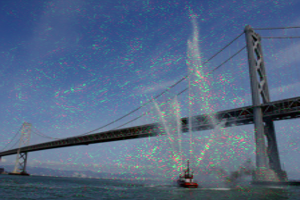

In [7]:
from VisualizationLibrary.visualization_lib import Visualize, show_pil_image, pil_image

pil_image(Visualize(
    *prepare_plots(u[:, 0].detach().view(3, 224, 224), input_image),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)).resize((v//4 for v in image.size))